# Import Packages for REINFORCE

In [1]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 14.5 MB/s eta 0:00:00


In [2]:
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from tqdm import tqdm
import matplotlib.pyplot as plt

# We'll use OmegaConf to manage hyperparameters!

In [3]:
!pip install omegaconf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=419e3273d56a0252239fdb33e4086d45836a990556e0db4bb50fcdbcbc806958
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [4]:
from omegaconf import OmegaConf

# Environment
- LunarLander-v2
![image.png](attachment:image.png)

In [11]:
!pip install swig
!pip install box2d-py
!pip install gymnasium[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached swig-4.1.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp310-cp310-linux_x86_64.whl size=2812318 sha256=f9fb554d4f408df1da95cc5dc2c8050a1d406a8bd4d0beab8331ca4d5e413640
  Stored in directory: /root/.cache/pip/wheels/47/01/d2/6a780da77ccb98b1d2facdd520a8d10838a03b590f6f8d50c0
Successfully built box2d-py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.7 MB)
  Created wheel for box2d-py: filename

In [12]:
env = gym.make('LunarLander-v2')
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v2>>>>>

# Hyperparameters
- Now they are in dictionary

In [13]:
config = OmegaConf.create({
    # DQN parameters
    'gamma': 0.999,
    
    # policy network parameters
    'device': 'cuda:0',
    'hidden_dim': 32,
    'state_dim': env.observation_space.shape[0],
    'action_dim': int(env.action_space.n),

    # learning parameters
    'learning_rate': 0.002,
})

# you can access in both ways:
config.gamma == config['gamma']

True

# Agent Class

In [14]:
class REINFORCE_Agent(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.data = []
        self.config = config
        
        self.policy_network = nn.Sequential(
            nn.Linear(self.config.state_dim, self.config.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.config.hidden_dim, self.config.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.config.hidden_dim, self.config.action_dim),
        )
        
        # load network to gpu (if available)
        self.to(self.config.device)
        
        # optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.config.learning_rate)
        
    def forward(self, state):
        return self.policy_network(state)
    
    # save data
    def put_data(self, item):
        self.data.append(item)
        
    # train network
    def train_net(self):
        R = 0
        self.optimizer.zero_grad()
        
        # compute return & backward
        for r, log_prob in self.data[::-1]:
            R = r + self.config.gamma * R
            loss = -log_prob * R
            loss.backward()
        
        self.optimizer.step()
        
        # clear data
        self.data = []

# Run

In [16]:
num_epis, epi_rews = 5000, []
agent = REINFORCE_Agent(config)

for n_epi in tqdm(range(num_epis)):
    state, _ = env.reset()
    terminated, truncated = False, False
    epi_rew = 0
    
    while not (terminated or truncated):
        # get action prob from agent & sample -- use Categorical!
        action_logits = agent.forward(torch.FloatTensor(state).to(config.device))
        action_probs = F.softmax(action_logits, dim=-1)
        action_dist = Categorical(action_probs)
        action = action_dist.sample()
        
        # step & get results
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        
        # save r & p(a|s)
        agent.put_data((reward, torch.log(action_probs[action])))
        
        # transition
        state = next_state
        
        # record
        epi_rew += reward
        
    # train
    agent.train_net()
    
    # record
    epi_rews += [epi_rew]
    
env.close()

100%|██████████| 5000/5000 [50:15<00:00,  1.66it/s]


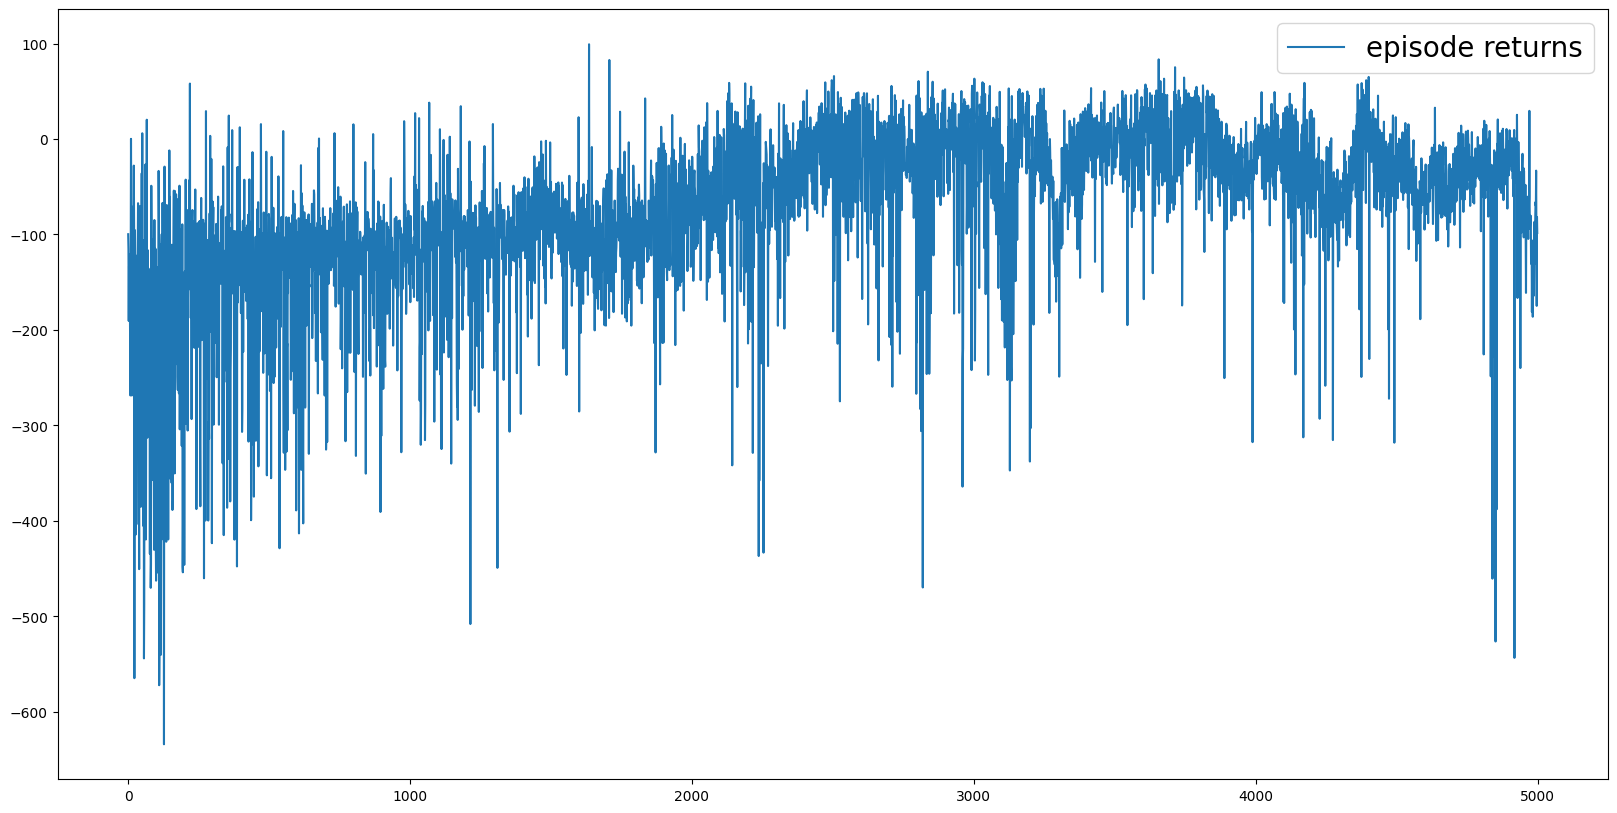

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(epi_rews, label='episode returns')
plt.legend(fontsize=20)
plt.show()
plt.close()